*This is an initial look into paths of classifying monet paintings. Due to current status may be worth even trying to do more genre based vs. artist based look into the situation.* 
  
*The created neural network used keras on top of a theano backend. Currently using a three stage network to categorize the images.*

In [ ]:
import theano

from keras.models import Sequential        # Linear stack


from keras.layers import (                 
    # Flattened list of layers
    
                          Convolution2D,   
                            # Filters via windows of 2d input
                          MaxPooling2D,    
                            # Subsets image into matrices, largest value of matrix is taken
                          Activation,      
                            # Filters tha activate when deisred features are identified
                          Dropout,         
                            # Prevents overfitting by dropping based on probability 1-p
                          Flatten,         
                            # Layers comprising model graph
                          Dense            
                            # Specify input argument shape
    
                          )
import matplotlib.pyplot as plt
%matplotlib inline

*In order to start it is important to begin by prcessing the data. This is a quick look into how it's done, will do quick demo*   
  
*Basically the image that will be looked at is taken, processed in a number of different ways (flipped, skewed, cropped, etc.). This is like turning a signature upside down for forgery. Looking at the situation through several angles.*

In [ ]:
# Data Cleaning and Preparation

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



d_gen = ImageDataGenerator( featurewise_center = False, # input mean as 0 over data
                            samplewise_center = False,  # Set sample mean to 0
                            featurewise_std_normalization=False, # Standardize around std of dataset 
                            samplewise_std_normalization=False,  # Standardize around std of sample
                            zca_whitening=False, # Apply ZCA whitening
                           
                            rotation_range=0.15,   # Random Roation within specified range
                            width_shift_range=0.15, # Horizontal shift as a fractional of image width
                            height_shift_range=0.15, # Vertical shift as fraction of image height
                            shear_range=0.15, # Intensity of shear
                            zoom_range=0.15, # Either number or list, but specifies the range for the random zoom
                            
                            channel_shift_range=0., # Range for random channel shifts
                            fill_mode='nearest', # How pixels outside of the boundary are dealt with
                            cval=0., # color value for fill_mode if that value was set to 'constant'
                            horizontal_flip=True, # Random horizontal flip of sample
                            vertical_flip=True, # Random vertical flip of sample
                            rescale=1./225, # Scalar multiplying the image. 1 used  
#                             dim_ordering=K.image_dim_ordering()
                          )

In [ ]:
monet1 = load_img('Claude_Monet,_Impression,_soleil_levant.jpg') # PIL image
monet_array = img_to_array(monet1) # Convert the 2d Image to an array
monet_array = monet_array.reshape((1,) + monet_array.shape) # Reshape to 1D

Show the purdy pictures.

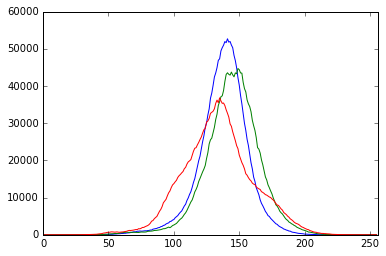

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


img = cv2.imread('mod/Claude_Monet,_Impression,_soleil_levant.jpg')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
t = 0
for batch in d_gen.flow(monet_array, batch_size=1,
                        save_to_dir='mod', save_prefix='monet', 
                        save_format='jpeg'):
    t += 1
    if t > 20: # Create 20 manipulated images
        break 

# Creation of the Model

*Here is where the model is created. So far the model that is being used is a rather simple three step neural network. Then going to build out a bit more*

In [ ]:

model = Sequential()
model.add(Convolution2D(32,3,3, input_shape=(3,150,150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4)))

# Build the model

In [ ]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))           # Rectified Linear Unit
model.add(Dropout(0.6))                 # Drop 50% of the Neurons
model.add(Dense(1))
model.add(Activation('sigmoid'))        # Yay, sigmoids
model.add(Activation('relu'))           # Rectified Linear Unit
model.add(Dropout(0.5)) 

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# use the above datagen for training
d_gen = ImageDataGenerator(rescale=1./255,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True)

# For test only use a rescale function
test_d_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
monet_gen = d_gen.flow_from_directory('/home/sambozek/Desktop/Modified Data Set/Test',       # Folder containing the test images
                                     target_size = (150, 150),              # Resize to 150 * 150 pxs
                                     batch_size = 32,                       # Reduce Noise, larger batch less noise
                                     class_mode='binary')                   # Binary Classification Problem

hold_out = test_d_gen.flow_from_directory('/home/sambozek/Desktop/Modified Data Set/Hold Out/',
                                         target_size= (150, 150),
                                         batch_size = 32,
                                         class_mode='binary')

To avoid `Epoch comprised more than 'samples_per_epoch' samples` error need to make sure that batch size is divisible into 

In [ ]:
model.fit_generator(monet_gen,                  # Resize the image get from test dictionary
                   samples_per_epoch=640,      # How many samples to use per epoch
                   nb_epoch=100,                 # Number of epochs used
                   validation_data = hold_out,  # Location of the validation data
                   nb_val_samples=640,          # Validation samples used per epoch
                   verbose=1)

model.save_weights('monet_weights.h5', overwrite=True)

In [ ]:
monet_model = model.to_json() # Save model to json

* Test : 
    * Monet:
    * Not Monet:
* Hold Out: **No Issues**
    * Monet:
    * Not Monet:

*Initial running of the model found there was an issue with the image files and was given this error message:  
**IOError: image file is truncated (39 bytes not processed)**  
From [StackOverflow](http://bit.ly/21oXdhF) it was found that the images were likely corrupted or had unneeded trailing bytes. In order to find these truncated files used [jpeginfo](https://github.com/tjko/jpeginfo) to create a text file of the analysis of the jpegs. Output read by pandas allows for isolation of the trouble data.*


!jpeginfo -c *.jpg >> Test_monet.txt

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# test_monet = pd.read_csv("/Users/sebozek/Desktop/Test.txt",delim_whitespace=True,header=None)
# test_not_monet = pd.read_csv("/Users/sebozek/Desktop/Test.txt",delim_whitespace=True,header=None)
# val_monet = pd.read_csv("/Users/sebozek/Desktop/HoldOut.txt",delim_whitespace=True,header=None, error_bad_lines=False)
# val_not_monet = pd.read_csv("/Users/sebozek/Desktop/HoldOut_nm.txt", delim_whitespace=True, header=None,  error_bad_lines=False)

In [ ]:
# dfs = [test_monet, test_not_monet, val_monet, val_not_monet]

# # More Descriptive Labels
# for df in dfs:
#     df.columns = ["img_name", "width", "x", 'height', 'bits', 'format', 'N/P', 'pixels', 'test']

In [ ]:
# for df in dfs:
#     print df.test.unique()
    
# print val_not_monet.test.unique()

In [ ]:
# val_not_monet['img_name'][val_not_monet.test == '[ERROR]'].values

## To Do

* Expand to try categorizing styles?
* Figure out a few hatches
* Try getting to above a 95% accuracy
* Manipulate loss functions
* Change the dropout rate and see what's going on
* Validation
    * ROC curve
    * Confusion Matrix
* What does model think is important?
* Restricted Boltzmann Machine for Monet Replication

In [ ]:
# Import previous model (that worked)
model.load_weights('my_model_weights.h5')

# Get image output
output_1 = K.function([model.layers[0].input],
                     [model.layers[1].output])

In [ ]:
import json

with open('model.txt', 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
test_not_monet.head(1)